# Bachelor project
The aim of this work is to train convolutional neural network (CNN)  model, that will be capable to identify glaucomatous fundus images with high accuracy and to implement a user-friendly interface for working with this model. This will be tackled via the following objectives:
- Propose and implement preprocessing and augmentation for colorful fundus images.
- Design and implement multiple convolutional neural network (CNN) models, compare their performance, and choose the best model.
- Develop and implement a user-friendly interface to easily interact with the model.

## Preprocessing

### Combine all datasets

In [7]:
import os
import shutil

# New folders
output_dir = "data/combined"
os.makedirs(os.path.join(output_dir, "healthy"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "glaucoma"), exist_ok=True)

# Images from other datasets
dataset_paths = {
    "healthy": [
        "data/datasets/Drishti/NORMAL",
        "data/datasets/LAG_database/LAG_database_part_1 2/non_glaucoma/image",
    ],
    "glaucoma": [
        "data/datasets/Drishti/GLAUCOMA",
        "data/datasets/LAG_database/LAG_database_part_1 2/suspicious_glaucoma/image",
    ],
}

# Copying files from specified paths
for category, paths in dataset_paths.items():
    for path in paths:
        if os.path.exists(path):
            for img_name in os.listdir(path):
                src_path = os.path.join(path, img_name)
                dst_path = os.path.join(output_dir, category, img_name)
                shutil.copy(src_path, dst_path)

# Process RIM-ONE dataset
rimone_path = "data/datasets/RIM-ONE"

if os.path.exists(rimone_path):
    for img_name in os.listdir(rimone_path):
        src_path = os.path.join(rimone_path, img_name)
        # Check if file name starts with 'S' or 'G' for glaucoma, or 'N' for healthy
        if img_name.startswith("S") or img_name.startswith("G"):
            dst_path = os.path.join(output_dir, "glaucoma", img_name)
            shutil.copy(src_path, dst_path)
        elif img_name.startswith("N"):
            dst_path = os.path.join(output_dir, "healthy", img_name)
            shutil.copy(src_path, dst_path)

print("Files successfully combined!")


Files successfully combined!


Check how many images of each class we have.

In [8]:
import os

glaucoma_path = "data/combined/glaucoma"
healthy_path = "data/combined/healthy"

num_glaucoma = len(os.listdir(glaucoma_path)) if os.path.exists(glaucoma_path) else 0
num_healthy = len(os.listdir(healthy_path)) if os.path.exists(healthy_path) else 0

print(f"Glaucoma images: {num_glaucoma}"
      f"\nHealthy images: {num_healthy}")

Glaucoma images: 1855
Healthy images: 3259


From the code above we can tell, that there is almost 2x difference between amount of glaucoma and healthy images. So we have to make an augmentation for glaucoma images, but before that we have to normalize data.

### Image normalization (No need here as it's only rescaling and doesn't help with accuracy)
1. Resize the image to a fixed size for consistency.
2. Convert image from color to grayscale to simplify the image and reduce data complexity.
3. Apply Gaussian Blur to reduce noise and smooth the image.
4. Apply histogram equalization to improve contrast (Enhance the image contrast by spreading out the most frequent intensity values.)
5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD).
6. Normalize the image: scale pixel values to the range [0, 1]

In [9]:
import os
import cv2
import numpy as np

# Directories containing the original images
glaucoma_src = 'data/combined/glaucoma'
healthy_src = 'data/combined/healthy'
    
# Directories where the preprocessed images will be saved
glaucoma_dest = 'data/preprocessed/glaucoma'
healthy_dest = 'data/preprocessed/healthy'
    
# Create destination directories if they don't exist
os.makedirs(glaucoma_dest, exist_ok=True)
os.makedirs(healthy_dest, exist_ok=True)

# Define the target image size (width, height)
img_size = (224, 224)

# Possible preprocessing steps:
# 1. Resize the image to a fixed size for consistency.
# 2. Convert image from color to grayscale to simplify the image and reduce data complexity. (not used, because drops accuracy)
# 3. Apply Gaussian Blur to reduce noise and smooth the image. (improves accuracy a little for bigger model, but drops significantly for smaller model)
# 4. Apply histogram equalization to improve contrast (not used, because it has to receive a grayscale image, which drops accuracy)
# 5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD). (not used, because drops accuracy)
# 6. Normalize the image: scale pixel values to the range [0, 1]
def process_and_save_images(src_folder, dest_folder):
    image_files = os.listdir(src_folder)
    for file in image_files:
        src_path = os.path.join(src_folder, file)
        img = cv2.imread(src_path)
        if img is not None:
            # 1. Resize the image to a fixed size for consistency.
            img = cv2.resize(img, img_size)
            
            # 2. Convert image from color to grayscale to simplify the image and reduce data complexity.
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # 3. Apply Gaussian Blur to reduce noise and smooth the image.
            # img = cv2.GaussianBlur(img, (5, 5), 0)
            
            # 4. Apply histogram equalization to improve contrast (Enhance the image contrast by spreading out the most frequent intensity values.)
            # img = cv2.equalizeHist(img)
            
            # 5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD).
            # img = cv2.medianBlur(img, 3)

            # To save the image, convert normalized image back to uint8 format (for cv2.imwrite)
            img_to_save = (img).astype(np.uint8)
            dest_path = os.path.join(dest_folder, file)
            cv2.imwrite(dest_path, img_to_save)

# Process and save images for both classes
process_and_save_images(glaucoma_src, glaucoma_dest)
process_and_save_images(healthy_src, healthy_dest)

print("Preprocessing and saving completed!")

Preprocessing and saving completed!


### Augmentation
Just vertical flip for glaucoma images.

In [10]:
import os
import cv2
import numpy as np

# Directories containing preprocessed healthy and glaucoma images
healthy_src = 'data/combined/healthy'
glaucoma_src = 'data/combined/glaucoma'

# Define destination directories for final images
dest_healthy = 'data/augmented/healthy'
dest_glaucoma = 'data/augmented/glaucoma'

# Create destination directories if they don't exist
os.makedirs(dest_healthy, exist_ok=True)
os.makedirs(dest_glaucoma, exist_ok=True)

# Process healthy images: simply copy them to the destination folder
for file in os.listdir(healthy_src):
    src_path = os.path.join(healthy_src, file)
    dst_path = os.path.join(dest_healthy, file)
    image = cv2.imread(src_path)
    if image is not None:
        cv2.imwrite(dst_path, image)

# Process glaucoma images: for each image, apply multiple augmentations and save
for file in os.listdir(glaucoma_src):
    src_path = os.path.join(glaucoma_src, file)
    image = cv2.imread(src_path)
    if image is not None:
        # Save the original image
        dst_path_orig = os.path.join(dest_glaucoma, file)
        cv2.imwrite(dst_path_orig, image)
        
        # Extract base name and extension for creating augmented file names
        base_name, ext = os.path.splitext(file)
        
        # Vertical flip
        img_vflip = cv2.flip(image, 0)
        cv2.imwrite(os.path.join(dest_glaucoma, f"{base_name}_vflip{ext}"), img_vflip)

print("Healthy images copied and glaucoma images augmented (doubled) successfully!")

Healthy images copied and glaucoma images augmented (doubled) successfully!


In [11]:
import os

glaucoma_path = "data/augmented/glaucoma"
healthy_path = "data/augmented/healthy"

num_glaucoma = len(os.listdir(glaucoma_path)) if os.path.exists(glaucoma_path) else 0
num_healthy = len(os.listdir(healthy_path)) if os.path.exists(healthy_path) else 0

print(f"Glaucoma images: {num_glaucoma}"
      f"\nHealthy images: {num_healthy}")

Glaucoma images: 3710
Healthy images: 3259


## Model training

### Splitting into training and testing dataset

In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source directories for each class
source_glaucoma = 'data/augmented/glaucoma'
source_healthy = 'data/augmented/healthy'

# Define destination directories for train and test splits
dest_train_glaucoma = 'data/split/train/glaucoma'
dest_train_healthy = 'data/split/train/healthy'
dest_test_glaucoma = 'data/split/test/glaucoma'
dest_test_healthy = 'data/split/test/healthy'

# Create destination directories if they don't exist
os.makedirs(dest_train_glaucoma, exist_ok=True)
os.makedirs(dest_train_healthy, exist_ok=True)
os.makedirs(dest_test_glaucoma, exist_ok=True)
os.makedirs(dest_test_healthy, exist_ok=True)

# Get list of file names from each source directory
files_glaucoma = os.listdir(source_glaucoma)
files_healthy = os.listdir(source_healthy)

# Split file names into training and testing sets for each class
train_glaucoma, test_glaucoma = train_test_split(files_glaucoma, test_size=0.2, random_state=42)
train_healthy, test_healthy = train_test_split(files_healthy, test_size=0.2, random_state=42)

# Copy glaucoma images to corresponding train and test directories
for file in train_glaucoma:
    src_path = os.path.join(source_glaucoma, file)
    dst_path = os.path.join(dest_train_glaucoma, file)
    shutil.copy(src_path, dst_path)

for file in test_glaucoma:
    src_path = os.path.join(source_glaucoma, file)
    dst_path = os.path.join(dest_test_glaucoma, file)
    shutil.copy(src_path, dst_path)

# Copy healthy images to corresponding train and test directories
for file in train_healthy:
    src_path = os.path.join(source_healthy, file)
    dst_path = os.path.join(dest_train_healthy, file)
    shutil.copy(src_path, dst_path)

for file in test_healthy:
    src_path = os.path.join(source_healthy, file)
    dst_path = os.path.join(dest_test_healthy, file)
    shutil.copy(src_path, dst_path)

print("Data split into train and test folders successfully!")

Data split into train and test folders successfully!


### Training

#### v1

In [13]:
import os
import pickle
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Parameters: image dimensions, batch size, and number of epochs
img_width, img_height = 224, 224
batch_size = 32
epochs = 15

# Data directories for training and testing
train_data_dir = 'data/split/train'
test_data_dir = 'data/split/test'

# Create ImageDataGenerators with basic preprocessing (rescaling)
train_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen = ImageDataGenerator(rescale=1.0/255) 

# Load training data from directory with explicitly defined class order: first 'healthy', then 'glaucoma'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma']  # Explicit class order
)

# Load test data from directory; disable shuffling for accurate evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Keep order for proper evaluation
    classes=['healthy', 'glaucoma']
)

# Build the Convolutional Neural Network (CNN) model
model = Sequential([
    InputLayer(shape=(img_width, img_height, 3)),        # Input layer for RGB images
    Conv2D(32, (3, 3), activation='relu'),               # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                        # First max pooling layer
    Conv2D(64, (3, 3), activation='relu'),               # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                        # Second max pooling layer
    Conv2D(128, (3, 3), activation='relu'),              # Third convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                        # Third max pooling layer
    Flatten(),                                           # Flatten the feature maps
    Dense(128, activation='relu'),                       # Fully connected layer
    Dropout(0.5),                                        # Dropout layer for regularization
    Dense(1, activation='sigmoid')                       # Output layer for binary classification
])

# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# Train the model using the training generator and validate with the test generator
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Save history of training to a file
history_path = "models/history_v1.pkl"
os.makedirs(os.path.dirname(history_path), exist_ok=True)
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

# Evaluate the model performance on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the trained model in Keras format
model.save("models/cnn_model_v1.keras")

Found 5575 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 68s 385ms/step - accuracy: 0.5947 - loss: 0.6682 - val_accuracy: 0.7776 - val_loss: 0.5026
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 68s 388ms/step - accuracy: 0.7685 - loss: 0.4995 - val_accuracy: 0.8465 - val_loss: 0.3691
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 68s 389ms/step - accuracy: 0.8035 - loss: 0.4405 - val_accuracy: 0.7862 - val_loss: 0.4227
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 401ms/step - accuracy: 0.8286 - loss: 0.3841 - val_accuracy: 0.8766 - val_loss: 0.3031
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 66s 376ms/step - accuracy: 0.8548 - loss: 0.3419 - val_accuracy: 0.8752 - val_loss: 0.2897
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 66s 375ms/step - accuracy: 0.8756 - loss: 0.3026 - val_accuracy: 0.8953 - val_loss: 0.2573
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 396ms/step - accuracy: 0.8849 - loss: 0.2762 - val_accuracy: 0.8931 - val_loss: 0.2644
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 68s 390ms/step - accuracy: 0.8917 - loss: 0

#### v2

In [14]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Parameters: image dimensions, batch size, and number of epochs
img_width, img_height = 224, 224
batch_size = 32
epochs = 15

# Data directories for training and testing
train_data_dir = 'data/split/train'
test_data_dir = 'data/split/test'

# Create ImageDataGenerators with basic preprocessing (rescaling)
train_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen = ImageDataGenerator(rescale=1.0/255) 

# Load training data from directory with explicitly defined class order: first 'healthy', then 'glaucoma'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma']  # Explicit class order
)

# Load test data from directory; disable shuffling for accurate evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Keep order for proper evaluation
    classes=['healthy', 'glaucoma']
)

# Build the Convolutional Neural Network (CNN) model
model = Sequential([
    InputLayer(shape=(img_width, img_height, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# Train the model using the training generator and validate with the test generator
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Save history of training to a file
history_path = "models/history_v2.pkl"
os.makedirs(os.path.dirname(history_path), exist_ok=True)
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

# Evaluate the model performance on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the trained model in Keras format
model.save("models/cnn_model_v2.keras")

Found 5575 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 197136)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     6,308,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,308,865 (24.07 MB)

 Trainable params: 6,308,865 (24.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.7103 - loss: 0.5576 - val_accuracy: 0.8393 - val_loss: 0.4125
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 173ms/step - accuracy: 0.8239 - loss: 0.4271 - val_accuracy: 0.8537 - val_loss: 0.3586
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 173ms/step - accuracy: 0.8434 - loss: 0.3616 - val_accuracy: 0.8838 - val_loss: 0.3091
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 173ms/step - accuracy: 0.8586 - loss: 0.3332 - val_accuracy: 0.8945 - val_loss: 0.2880
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.8786 - loss: 0.2932 - val_accuracy: 0.8357 - val_loss: 0.3673
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 31s 176ms/step - accuracy: 0.8852 - loss: 0.2850 - val_accuracy: 0.9067 - val_loss: 0.2645
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 31s 176ms/step - accuracy: 0.8938 - loss: 0.2567 - val_accuracy: 0.9003 - val_loss: 0.2608
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 31s 178ms/step - accuracy: 0.9062 - loss: 0

#### v3

In [15]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Parameters: image dimensions, batch size, and number of epochs
img_width, img_height = 224, 224
batch_size = 32
epochs = 15

# Data directories for training and testing
train_data_dir = 'data/split/train'
test_data_dir = 'data/split/test'

# Create ImageDataGenerators with basic preprocessing (rescaling)
train_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen = ImageDataGenerator(rescale=1.0/255) 

# Load training data from directory with explicitly defined class order: first 'healthy', then 'glaucoma'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma']  # Explicit class order
)

# Load test data from directory; disable shuffling for accurate evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Keep order for proper evaluation
    classes=['healthy', 'glaucoma']
)

# Build the Convolutional Neural Network (CNN) model
model = Sequential([
    InputLayer(shape=(img_width, img_height, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# Train the model using the training generator and validate with the test generator
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Save history of training to a file
history_path = "models/history_v3.pkl"
os.makedirs(os.path.dirname(history_path), exist_ok=True)
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

# Evaluate the model performance on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the trained model in Keras format
model.save("models/cnn_model_v2.keras")

Found 5575 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 55s 309ms/step - accuracy: 0.6441 - loss: 0.6251 - val_accuracy: 0.8250 - val_loss: 0.4222
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 54s 306ms/step - accuracy: 0.7867 - loss: 0.4537 - val_accuracy: 0.8644 - val_loss: 0.3403
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 54s 307ms/step - accuracy: 0.8368 - loss: 0.3789 - val_accuracy: 0.8702 - val_loss: 0.3158
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 54s 305ms/step - accuracy: 0.8491 - loss: 0.3386 - val_accuracy: 0.8752 - val_loss: 0.3049
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 53s 302ms/step - accuracy: 0.8702 - loss: 0.3113 - val_accuracy: 0.8816 - val_loss: 0.2912
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 53s 301ms/step - accuracy: 0.8778 - loss: 0.2868 - val_accuracy: 0.8838 - val_loss: 0.2887
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 53s 300ms/step - accuracy: 0.8832 - loss: 0.2803 - val_accuracy: 0.8945 - val_loss: 0.2513
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 53s 301ms/step - accuracy: 0.9044 - loss: 0

## Testing

Model loaded from models/cnn_model_v3.keras
Found 1394 images belonging to 2 classes.


c:\Users\sahurai\Desktop\Bakalarka\Code\BachelorProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step

Overall Metrics:
Accuracy:  0.8809
Recall:    0.8450
Precision: 0.9248
F1 Score:  0.8831

Classification Report:
              precision    recall  f1-score   support

     healthy       0.84      0.92      0.88       652
    glaucoma       0.92      0.85      0.88       742

    accuracy                           0.88      1394
   macro avg       0.88      0.88      0.88      1394
weighted avg       0.88      0.88      0.88      1394



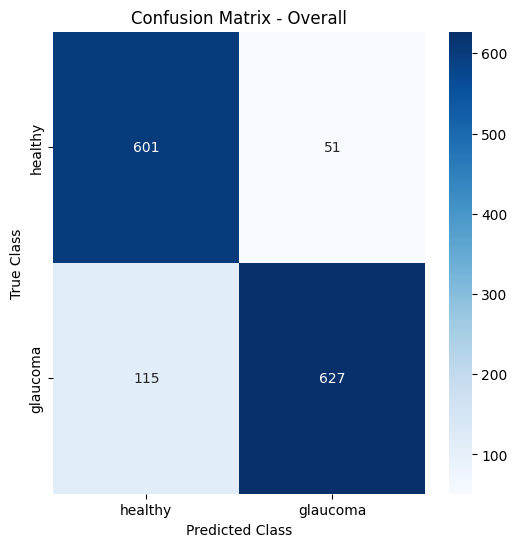

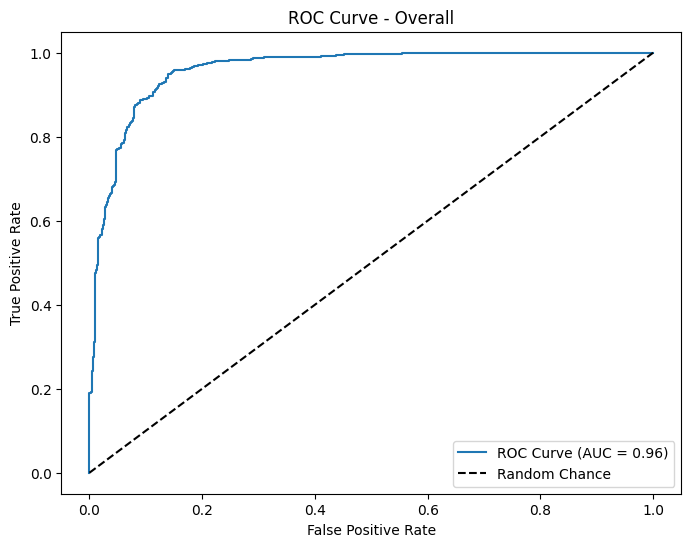

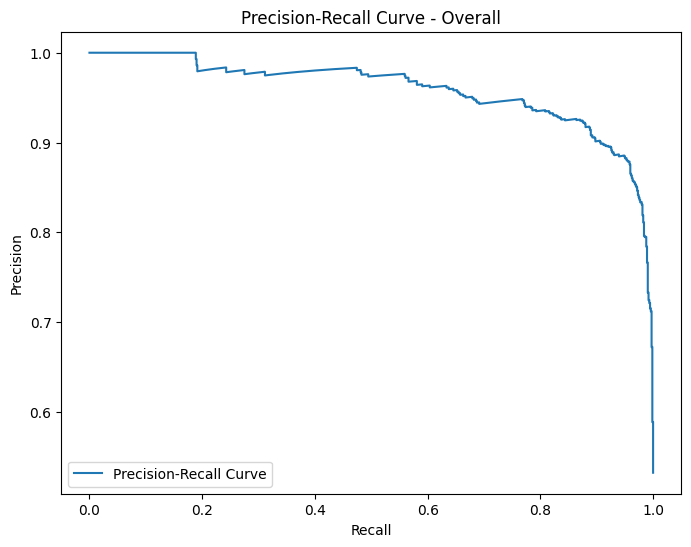

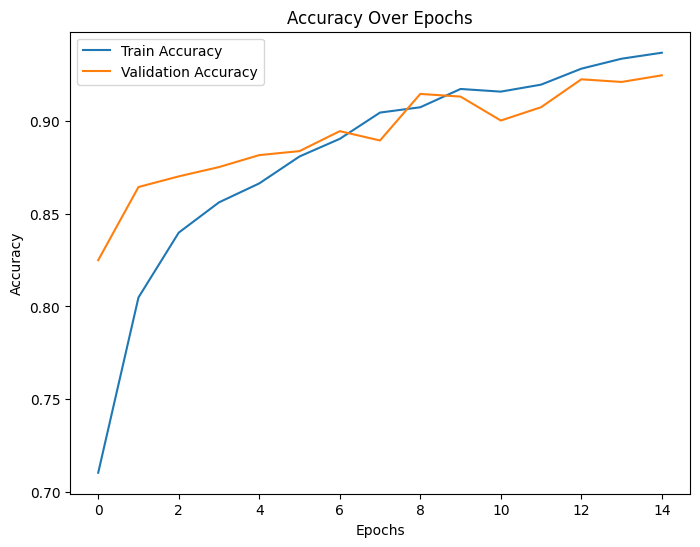

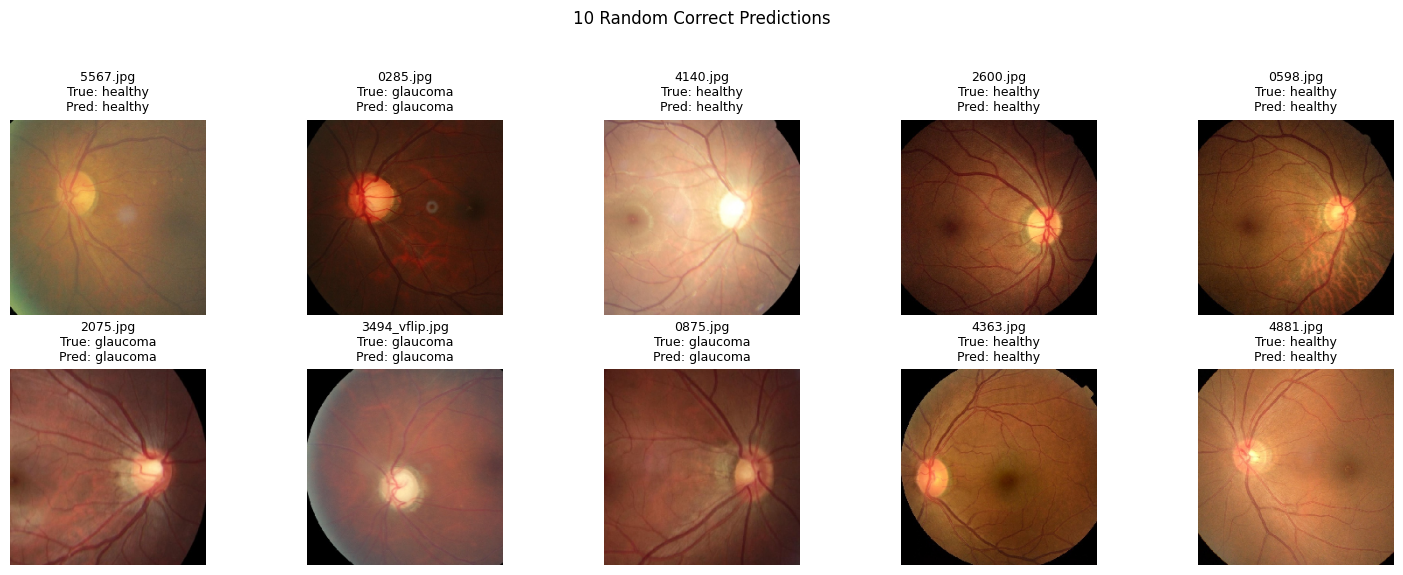

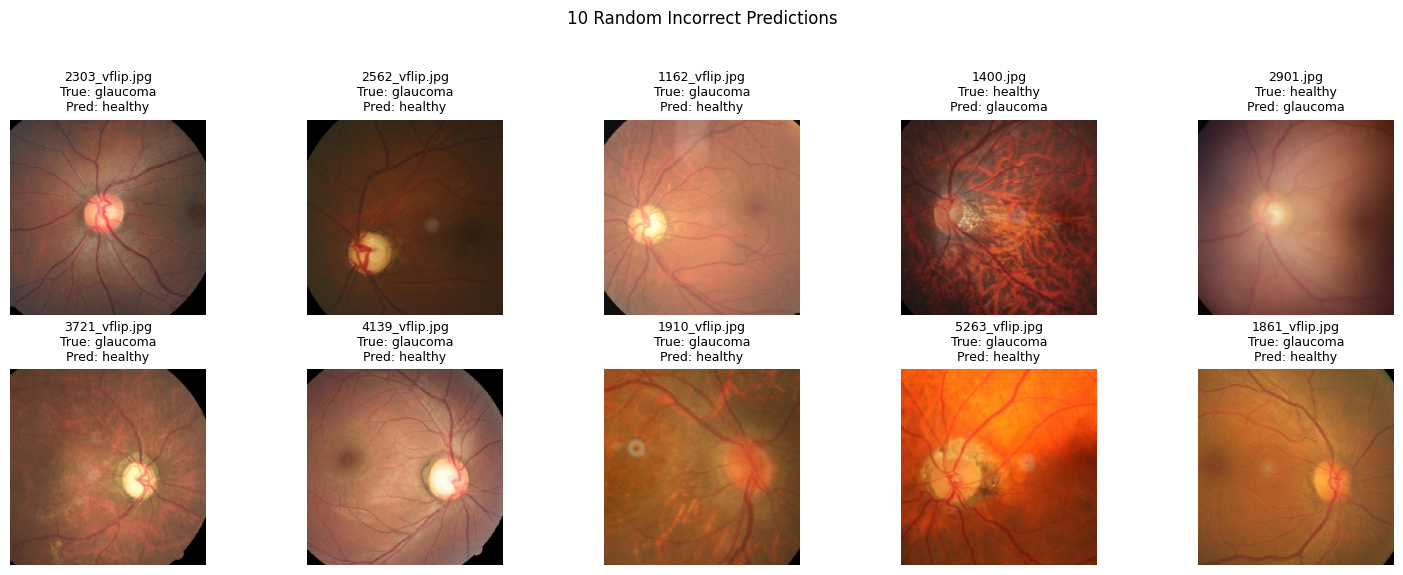


Total Correct Predictions: 1228
Total Incorrect Predictions: 166


In [16]:
import os
import math
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve)

# Parameters
img_width, img_height = 224, 224
batch_size = 32

# Load the trained model
model_path = "models/cnn_model_v3.keras"
history_path = "models/history_v3.pkl"
model = load_model(model_path)
print("Model loaded from", model_path)

# Define test data directory and class order (0: healthy, 1: glaucoma)
test_data_dir = 'data/split/test'
classes = ['healthy', 'glaucoma']

# Create ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load test data using flow_from_directory (order preserved for evaluation)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Do not shuffle for evaluation consistency
    classes=classes
)

# Retrieve filenames and true labels from the generator
filenames = test_generator.filenames
true_labels = test_generator.classes

# Predict on the test data
test_generator.reset()
pred_probs = model.predict(test_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# ----- Compute Overall Metrics -----
acc = accuracy_score(true_labels, pred_labels)
rec = recall_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels)
f1_val = f1_score(true_labels, pred_labels)
print("\nOverall Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score:  {f1_val:.4f}\n")

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=classes))

# ----- Confusion Matrix -----
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - Overall')
plt.show()

# ----- ROC Curve & AUC -----
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Overall')
plt.legend(loc='lower right')
plt.show()

# ----- Precision-Recall Curve -----
precision_vals, recall_vals, _ = precision_recall_curve(true_labels, pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Overall')
plt.legend(loc='lower left')
plt.show()

# ----- Plot Accuracy over Epochs -----
try:
    # Attempt to load training history (which is a dictionary)
    with open(history_path, "rb") as f:
        loaded_history = pickle.load(f)
    if 'accuracy' in loaded_history and 'val_accuracy' in loaded_history:
        plt.figure(figsize=(8, 6))
        plt.plot(loaded_history['accuracy'], label='Train Accuracy')
        plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()
        plt.show()
    else:
        print("Accuracy metrics not found in training history.")
except Exception as e:
    print("Training history not available:", e)

# ----- Collect Test Images for Visualization -----
# Load all test images into memory (assumes dataset is small)
steps = math.ceil(test_generator.samples / test_generator.batch_size)
X_test = []
Y_test = []
for i in range(steps):
    x_batch, y_batch = next(test_generator)
    X_test.append(x_batch)
    Y_test.append(y_batch)
X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

# ----- Identify Correct and Incorrect Predictions -----
correct_indices = [i for i in range(len(true_labels)) if pred_labels[i] == true_labels[i]]
incorrect_indices = [i for i in range(len(true_labels)) if pred_labels[i] != true_labels[i]]

# Randomly select 10 indices from each (if available)
num_samples = 10
random_correct = random.sample(correct_indices, min(num_samples, len(correct_indices)))
random_incorrect = random.sample(incorrect_indices, min(num_samples, len(incorrect_indices)))

# ----- Visualization Function -----
def visualize_samples(indices, title, n_images=10):
    selected = indices[:n_images]
    n = len(selected)
    # Arrange in 2 rows if possible (2 rows x ceil(n/2) columns)
    rows = 2 if n > 5 else 1
    cols = math.ceil(n / rows)
    plt.figure(figsize=(cols * 3, rows * 3))
    for j, idx in enumerate(selected):
        plt.subplot(rows, cols, j + 1)
        plt.imshow(X_test[idx])
        true_class = classes[int(Y_test[idx])]
        pred_class = classes[pred_labels[idx]]
        plt.title(f"{os.path.basename(filenames[idx])}\nTrue: {true_class}\nPred: {pred_class}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ----- Visualize 10 Random Correct Predictions -----
visualize_samples(random_correct, "10 Random Correct Predictions")

# ----- Visualize 10 Random Incorrect Predictions -----
visualize_samples(random_incorrect, "10 Random Incorrect Predictions")

# ----- Total correct and incorrect -----
print(f"\nTotal Correct Predictions: {len(correct_indices)}")
print(f"Total Incorrect Predictions: {len(incorrect_indices)}")